Convolutional Neural Network to detect what animal is in an image

Imports

In [1]:
import torch # pytorch

import torchvision # to get data
import torchvision.transforms as transforms # to transform data
import torch.utils.data.dataloader # to load data
import os 

import matplotlib.pyplot as plt # to plot images 
import numpy as np

import torch.nn as nn # for pytorch layers and functions
import torch.nn.functional as F

from torchinfo import summary # for summary of model

import torch.optim as optim # optimizer

from timeit import default_timer as timer # to time training

Device Type

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # mps is for gpu training on macos
device = torch.device('cpu')
device

device(type='cpu')

Hyperparameters

In [3]:
image_size = (64,64)
data_root = './dataset/'
batch_size = 32 # number of training samples in one forward pass
num_workers = os.cpu_count() # number of "workers" putting data in to the machines RAM at once. this speeds up training on machines with multiple cores

nrow = 8 # images in each row when visualizing

epochs = 10 # number of passes on full image set

learning_rate = 0.001 # how much weights are adjusted with respect to loss gradient
weight_decay = 0.0001 # reduces weights with this constant. This ensures no large weights so no overfitting. It makes the model converge slower


Transform and Load Data

In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size), # resize image to 64,64
    transforms.ToTensor(), # convert image to Pytorch Tensor (channels x height x width)
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))]) # normalize pixel values [-1,1]

trainset = torchvision.datasets.ImageFolder(root=data_root + 'training_set',
                                            transform=transform)

trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root=data_root + 'test_set',
                                            transform=transform)

testloader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)
classes = ('cat', 'dog')

View Image and Label Shape

In [5]:
img, label = next(iter(trainloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, heigth, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, heigth, width]
Label shape: torch.Size([32])


Function to Show a Batch of Images and their Classes

In [6]:
def imshow(classes, nrow, img, labels):
    img = img / 2 + 0.5 # unnormalize image back to [-1,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() # show images 

    output_lines = []
    for j in range(batch_size):
        class_name = f'{classes[labels[j]]}'
        output_lines.append(class_name)
        if (j + 1) % nrow == 0:  # Check if it's the last image in the line
            output_lines.append('\n')  # Insert newline after every 8th image

    # Join the output lines into a single string and print
    output_string = ' '.join(output_lines)
    print(output_string)

Show Batch of Images and Classes

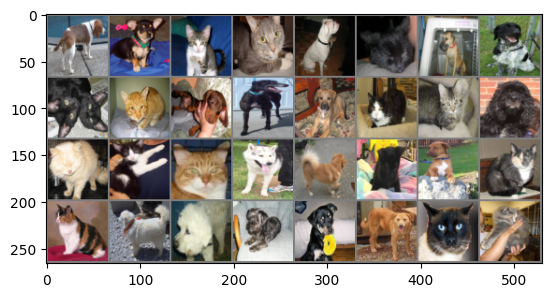

dog dog cat cat dog cat dog dog 
 cat cat dog dog dog cat cat dog 
 cat cat cat dog dog cat dog cat 
 cat dog dog dog dog dog cat cat 



In [9]:
# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(classes, nrow, torchvision.utils.make_grid(images, nrow=nrow), labels) # call function

Build Image Classifier

In [27]:
class neural_network(nn.Module):
    # initialize the layers
    def __init__(self): 
        super().__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, # 3 input channels for colored images (rgb)
                               out_channels=32, # filters applied to the input
                               kernel_size=3) # size of filter
        
        self.batch1 = nn.BatchNorm2d(32)
        # maxpool layer
        self.pool = nn.MaxPool2d(kernel_size=2,
                                  stride=2)
        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3)
        self.batch2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 14 * 14, 1)
        # output layer
        #self.fc2 = nn.Linear(64, 1)

        
    
    # perform a forward pass through the module
    def forward(self, x): 
        # convolutional w/relu + maxpool layers
        x = self.pool(F.relu(self.batch1(self.conv1(x))))
        x = self.pool(F.relu(self.batch2(self.conv2(x))))
        #print(x.size())
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) # will give dimensions : (batch, channels*height*width)
        #print(x.size())
        # fully connected layer
        x = F.sigmoid(self.fc1(x))
        # output layer
        #x = F.sigmoid(self.fc2(x))
        return x

# create the neural network
cnn = neural_network()
cnn.to(device)

neural_network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=1, bias=True)
)

Summary of Model

In [29]:
summary(cnn, input_size=[batch_size, 3, image_size[0] ,image_size[1]]) # model breakdown, 3 is for input channel

Layer (type:depth-idx)                   Output Shape              Param #
neural_network                           [32, 1]                   --
├─Conv2d: 1-1                            [32, 32, 62, 62]          896
├─BatchNorm2d: 1-2                       [32, 32, 62, 62]          64
├─MaxPool2d: 1-3                         [32, 32, 31, 31]          --
├─Conv2d: 1-4                            [32, 32, 29, 29]          9,248
├─BatchNorm2d: 1-5                       [32, 32, 29, 29]          64
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Linear: 1-7                            [32, 1]                   6,273
Total params: 16,545
Trainable params: 16,545
Non-trainable params: 0
Total mult-adds (M): 359.30
Input size (MB): 1.57
Forward/backward pass size (MB): 76.76
Params size (MB): 0.07
Estimated Total Size (MB): 78.40

Creating Training Function

In [30]:
# training function on one epoch
def train_step(model, dataloader, criterion, optimizer):
    model.train() # put model in train mode
    train_loss, train_acc, correct_predictions, total = 0, 0, 0, 0
    for batch, (X, y) in enumerate(dataloader,0): 
        
        X, y = X.to(device), y.to(device) # send to current device

        y_pred = model(X) # forward pass
        loss = criterion(y_pred, y.float().view(-1,1)) # calculate loss
        train_loss += loss.item() # extract loss value
        optimizer.zero_grad() # set gradients to zero
        loss.backward() # backpropagate
        optimizer.step() # use gradients from last step to update weights

        # y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # accuracy across all batches
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred) # loss across all batches

        y_pred_class = (y_pred > 0.5).float() # gives predictions for each image in a batch (0 or 1)
        correct_predictions += (y_pred_class == y.float().view(-1,1)).sum().item() 
        total += len(y)
        
    train_loss = train_loss / len(dataloader) # loss per batch
    train_acc = correct_predictions / total # accuracy per batch
    return train_loss, train_acc

Create Testing Function

In [31]:
# test the model on one epoch
def test_step(model, dataloader, criterion):
    model.eval() # turn on evaluation mode, for layers that behave differently during training and testing
    test_loss, test_acc, correct_predictions, total = 0, 0, 0, 0
    # dont keep track of gradients since we arent training 
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device) # send to current device
            y_pred = model(X) # forward pass
            loss = criterion(y_pred, y.float().view(-1,1))
            test_loss += loss.item()

            # test_y_pred = y_pred.argmax(dim=1)
            # test_acc = ((test_y_pred == y).sum().item()/len(test_y_pred))

            y_pred_class = (y_pred > 0.5).float() 
            correct_predictions += (y_pred_class == y.float().view(-1,1)).sum().item()
            total += len(y)

    test_loss = test_loss / len(dataloader)
    test_acc = correct_predictions / total
    return test_loss, test_acc

Function for Performing Train+Test 

In [32]:
# training + testing loop
def train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs): 
    # create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }
    # train + test for each epoch
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader,
                                           criterion=criterion,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    criterion=criterion)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Run Train + Test Function and Time It

In [33]:
criterion = nn.BCELoss() # type of loss function
optimzer = optim.Adam(params = cnn.parameters(), lr = learning_rate, weight_decay=weight_decay) # adam optimizer

start_time = timer()
model_results = train(model=cnn,
                      train_dataloader=trainloader,
                      test_dataloader=testloader,
                      optimizer=optimzer,
                      criterion=criterion,
                      epochs=epochs)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 0.6346 | train_acc: 0.6606 | test_loss: 0.6478 | test_acc: 0.6885
Epoch: 2 | train_loss: 0.5567 | train_acc: 0.7265 | test_loss: 0.5538 | test_acc: 0.7375
Epoch: 3 | train_loss: 0.4897 | train_acc: 0.7665 | test_loss: 0.5662 | test_acc: 0.7310
Epoch: 4 | train_loss: 0.4446 | train_acc: 0.7931 | test_loss: 0.5380 | test_acc: 0.7515
Epoch: 5 | train_loss: 0.4139 | train_acc: 0.8115 | test_loss: 0.5246 | test_acc: 0.7655
Epoch: 6 | train_loss: 0.3895 | train_acc: 0.8226 | test_loss: 0.5168 | test_acc: 0.7650
Epoch: 7 | train_loss: 0.3817 | train_acc: 0.8263 | test_loss: 0.5088 | test_acc: 0.7700
Epoch: 8 | train_loss: 0.3444 | train_acc: 0.8480 | test_loss: 0.5007 | test_acc: 0.7810
Epoch: 9 | train_loss: 0.3222 | train_acc: 0.8599 | test_loss: 0.4842 | test_acc: 0.7930
Epoch: 10 | train_loss: 0.3099 | train_acc: 0.8622 | test_loss: 0.5059 | test_acc: 0.7810
Total training time: 1135.138 seconds


Test Trained Model on a Batch

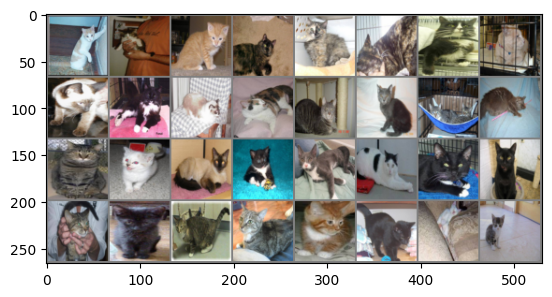

cat cat cat cat cat cat cat cat 
 cat cat cat cat cat cat cat cat 
 cat cat cat cat cat cat cat cat 
 cat cat cat cat cat cat cat cat 



In [34]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(classes, nrow, torchvision.utils.make_grid(images), labels)

In [35]:
outputs = cnn(images)
predicted = (outputs >= 0.5).float()
print('Predicted: ', ' '.join(f'{classes[int(predicted[j])]:5s}' for j in range(8)))

Predicted:  cat   cat   cat   dog   cat   cat   cat   cat  


Model 1:
- Pool[2,2](ReLU(Conv2D layer[3in,32out,k=3]))
- Pool[2,2](ReLU(Conv2D layer[32in,32out,k=3]))
- Flatten()
- ReLU(FC[32x14x14,64])
- Sigmoid(FC[64,1])
- batch_size = 32, 411681 parameters, 10 epochs,
- train_loss: 0.1099 | train_acc: 0.9636 | test_loss: 0.9872 | test_acc: 0.738
- Train Time: 1162.101 Seconds

Model 2:
- Pool[2,2](ReLU(Conv2D layer[3in,32out,k=3]))
- Pool[2,2](ReLU(Conv2D layer[32in,32out,k=3]))
- Pool[2,2](ReLU(Conv2D layer[32in,32out,k=3]))
- Flatten()
- ReLU(FC[32x6x6,64])
- Sigmoid(FC[64,1])
- batch_size = 32, 84,001 parameters, 10 epochs
- train_loss: 0.3243 | train_acc: 0.8550 | test_loss: 0.4760 | test_acc: 0.7890
- Train Time: 1149.599 Seconds

Model 3: 
- Pool[2,2](ReLU(Conv2D layer[3in,32out,k=3]))
- Pool[2,2](ReLU(Conv2D layer[32in,32out,k=3]))
- Pool[2,2](ReLU(Conv2D layer[32in,32out,k=3]))
- Flatten()
- ReLU(FC[32x6x6,128])
- ReLU(FC[128,128])
- Sigmoid(FC[128,1])
- batch_size = 32, 157,857 parameters, 10 epochs
- train_loss: 0.3042 | train_acc: 0.8680 | test_loss: 0.5012 | test_acc: 0.7825
- Train Time: 1133.29 Seconds


Model 4: 
- Pool[2,2](ReLU(BatchNorm[32](Conv2D layer[3in,32out,k=3])))
- Pool[2,2](ReLU(BatchNorm[32](Conv2D layer[32in,32out,k=3])))
- Flatten()
- Sigmoid(FC[32x14x14,1])
- batch_size = 32, 16,545 parameters, 10 epochs
- train_loss: 0.3099 | train_acc: 0.8622 | test_loss: 0.5059 | test_acc: 0.7810
- Train Time: 1135.138 Seconds
